In [2]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F

import PIL

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from os import path

In [3]:
train_data = torchvision.datasets.FashionMNIST(
    root=path.join("..", "data"),
    train=True,
    download=True,
    transform=torchvision.transforms.ToTensor(),
)

    # Download test data
test_data = torchvision.datasets.FashionMNIST(
    root=path.join("..", "data"),
    train=False,
    download=True,
    transform=torchvision.transforms.ToTensor(),
)

class is : 9
torch.float32
torch.Size([1, 28, 28])


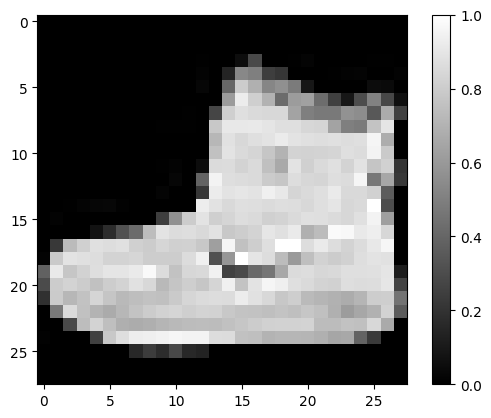

In [4]:
def _():
    image_tensor, cls = train_data[0]
    plt.imshow(image_tensor.squeeze(), cmap="grey")
    plt.colorbar()
    print(f"class is : {cls}")
    print(image_tensor.dtype)
    print(image_tensor.shape)
_()

In [5]:
torch.cuda.is_available()

True

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [7]:
image_to_tensor = torchvision.transforms.PILToTensor()
tensor_to_image = torchvision.transforms.ToPILImage()

In [8]:
image_tensor, cls = train_data[0]
print(f"shape : {image_tensor.shape}")
image = tensor_to_image(image_tensor)
image

shape : torch.Size([1, 28, 28])


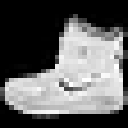

In [9]:
image.resize(size=(128,128,), resample=PIL.Image.NEAREST)

In [10]:
image.mode

'L'

In [11]:
class Model(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.flatten = nn.Flatten()
        self.layer1 = nn.Linear(28 * 28, 512)
        self.layer2 = nn.Linear(512, 512)
        self.layer3 = nn.Linear(512, 10)

    def forward(self, x):
        x0 = self.flatten(x)
        x1 = F.relu(self.layer1(x0))
        x2 = F.relu(self.layer2(x1))
        x3 = self.layer3(x2)
        return x3

tensor([[-0.0033,  0.0950,  0.0319, -0.0129,  0.0705,  0.0965,  0.0154,  0.0300,
          0.0819, -0.0518]])
tensor([0.0961, 0.1060, 0.0995, 0.0952, 0.1035, 0.1062, 0.0979, 0.0994, 0.1046,
        0.0916])


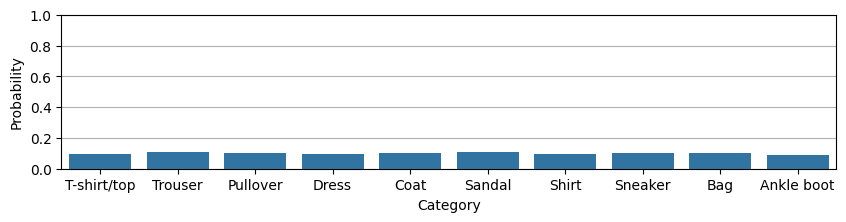

In [17]:
model_cpu = Model()
model_cpu.eval()

with torch.no_grad():
    logits = model_cpu(train_data[0][0])
print(logits)

probas = torch.nn.functional.softmax(logits, dim=-1).squeeze().detach().clone()
print(probas)

df = pd.DataFrame(
    {
        "Category": train_data.classes,
        "Probability": probas.numpy(),
    }
)

def _():
    plt.figure(figsize=(10, 2))
    plt.ylim(0.0, 1.0)
    plt.grid(True)
    sns.barplot(x="Category", y="Probability", data=df)
_()

In [18]:
image_tensor.shape

torch.Size([1, 28, 28])

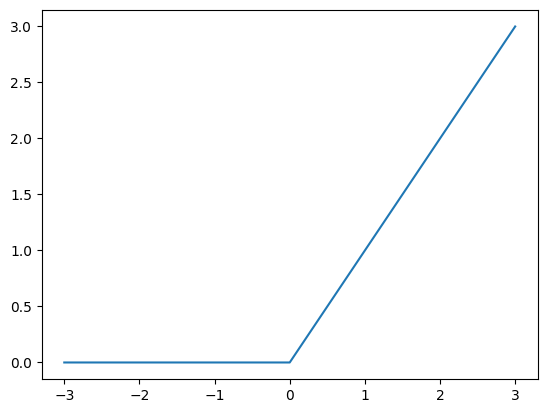

In [20]:
def _():
    relu = torch.nn.ReLU()
    input_1 = torch.linspace(-3.0, 3.0, 7)
    plt.plot(input_1, relu(input_1))
_()

In [21]:
loss_fn = torch.nn.CrossEntropyLoss()
loss_fn

CrossEntropyLoss()

It measures the difference between two probability distributions: here a computed probability distribution $p=(p_0, \dots, p_{n-1})$ and the "deterministic" distribution $e_i$ that states that the $i$ event is certain: every entry of $e_i$ is null but the $i$th which is equal to 1:

$$
e_i=(0, \dots, 0, 1, 0, \dots, 0)
$$

The difference is measured with:

$$
\mathrm{loss}(p, e_i) = - \sum_{j} e_{ij} \log p_j = - \log p_i. 
$$

The loss is zero when $p_i = 1$ (perfect match) and $\infty$ when $p_i = 0$. It does not depend on the distribution of the $p_j$ for $j \neq i$.

/// warning

The pytorch cross entropy function works directly with unnormalized log probabilities 

$$
\ell_i := \log p_i + c
$$

(the log probabilities up to a shared constant $c$) instead of the probabilites $p$. 
The deterministic distribution is also specified by the index $i$ instead of the vector $q=e_i$.
Hence, it actually computes

$$
\mathrm{loss}(\ell, i) := -\ell_i  + \log \left( \sum_je^{\ell_j} \right). 
$$

///

In [22]:
loss = loss_fn(
    input = torch.tensor([1.0, 0.0]).log(), 
    target = torch.tensor(1)
)
print(loss)
loss = loss_fn(
    input = torch.tensor([0.0, 1.0]).log(), 
    target = torch.tensor(1)
)
print(loss)

tensor(inf)
tensor(0.)


In [23]:
train_data_device = (train_data.data / 255).to(device)
train_labels_device = train_data.targets.to(device)

test_data_device = (test_data.data / 255).to(device)
test_labels_device = test_data.targets.clone().to(device)

In [24]:
batch_size = 64

In [25]:
class CustomDataSet:
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
    def __getitem__(self, key):
        return (self.data[key], self.labels[key],)
    def __len__(self):
        return len(self.data)

ds = CustomDataSet(train_data_device, train_labels_device)
dataloader = torch.utils.data.DataLoader(ds, batch_size=batch_size, shuffle=True)

test_ds = CustomDataSet(test_data_device, test_labels_device)
test_dataloader = torch.utils.data.DataLoader(test_ds, batch_size=batch_size, shuffle=True)

In [26]:
print(f"taille données : {len(dataloader.dataset)}")
print(f"taille batch : {len(dataloader)}")

taille données : 60000
taille batch : 938


In [39]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    num_batch = len(dataloader)
    model.train()

    total_loss = 0.

    for batch, [x, y] in enumerate(dataloader):
        pred = model(x)

        loss = loss_fn(pred, y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            current = (batch + 1) * len(x)
            loss_item = loss.item()
            print(f"loss: {loss_item:>7f}  [{current:>5d}/{size:>5d}]")

        total_loss += loss_item
    return total_loss / num_batch

In [40]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = (0, 0)
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss = test_loss + loss_fn(pred, y).item()
            correct = correct + (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss = test_loss / num_batches
    correct = correct / size
    print(
        f"Test Error: \n Accuracy: {100 * correct:>0.2f}%, Avg loss: {test_loss:>8f} \n"
    )
    return (correct, test_loss)

In [41]:
def learn(model, loss_fn, max_epoch=10, lr=1e-3):
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    epoch = 0

    results_loss_train = []
    results_loss_test = []
    results_accuracy = []

    while epoch < max_epoch:
        print(f"Epoch {epoch}\n-------------------------------")

        loss_train = train(dataloader, model, loss_fn, optimizer)
        accuracy, loss_test = test(dataloader, model, loss_fn)

        results_loss_train.append(loss_train)
        results_loss_test.append(loss_test)
        results_accuracy.append(accuracy)

        epoch += 1

    print("Done!")
    return results_loss_train, results_loss_test, results_accuracy

In [42]:
model_device = Model().to(device)
results_loss_train, results_loss_test, results_accuracy = learn(
    model_device, loss_fn, max_epoch=20, lr=1e-3
)

Epoch 0
-------------------------------
loss: 2.299372  [   64/60000]
loss: 2.284659  [ 6464/60000]
loss: 2.275223  [12864/60000]
loss: 2.264606  [19264/60000]
loss: 2.260121  [25664/60000]
loss: 2.242413  [32064/60000]
loss: 2.231890  [38464/60000]
loss: 2.221550  [44864/60000]
loss: 2.187754  [51264/60000]
loss: 2.166255  [57664/60000]
Test Error: 
 Accuracy: 44.78%, Avg loss: 2.166210 

Epoch 1
-------------------------------
loss: 2.163482  [   64/60000]
loss: 2.132343  [ 6464/60000]
loss: 2.145309  [12864/60000]
loss: 2.068768  [19264/60000]
loss: 2.054211  [25664/60000]
loss: 2.030387  [32064/60000]
loss: 2.044314  [38464/60000]
loss: 1.928693  [44864/60000]
loss: 1.946737  [51264/60000]
loss: 1.890814  [57664/60000]
Test Error: 
 Accuracy: 57.35%, Avg loss: 1.902383 

Epoch 2
-------------------------------
loss: 1.887116  [   64/60000]
loss: 1.914201  [ 6464/60000]
loss: 1.845791  [12864/60000]
loss: 1.755638  [19264/60000]
loss: 1.688825  [25664/60000]
loss: 1.723000  [32064/6

In [43]:
torch.save(model_device.state_dict(), path.join("..", "models", "model.pth"))

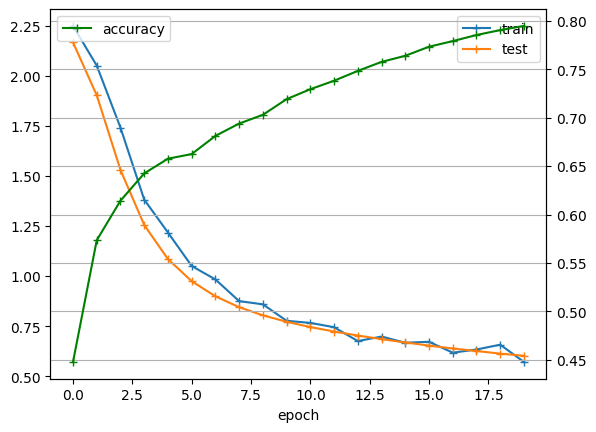

In [55]:
def _():

    x = range(len(results_loss_train))
    fig, ax1 = plt.subplots()
    ax1.set_xlabel("epoch")
    ax1.plot(x, results_loss_train, "+-", label="train")
    ax1.plot(x, results_loss_test, "+-", label="test")
    ax1.legend()

    ax2 = ax1.twinx()
    ax2.plot(x, results_accuracy, "+-", label="accuracy", color="green")
    ax2.legend()

    plt.grid(True)
    plt.show()

_()

classe : Bag


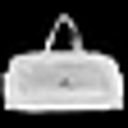

In [56]:
ix = 62
tensor, cls = test_data[ix]
str_cls = test_data.classes[cls]
print(f"classe : {str_cls}")

tensor_to_image(tensor).resize(size=(128, 128))

In [57]:
model_device.eval()
pred = model_device(tensor.to(device)).detach().cpu()
print("affichage des logits")
pred

affichage des logits


tensor([[-5.8347, -7.9854, -1.6646, -3.4118,  2.0396,  6.0272, -1.1488,  2.8754,
          8.1413,  2.4987]])

In [ ]:
probas = torch.nn.functional.softmax(pred, dim=-1).squeeze().detach().clone()

df = pd.DataFrame(
    {
        "Category": train_data.classes,
        "Probability": probas.numpy(),
    }
)
df["Probability"] = (df["Probability"] * 100.).round(decimals=2)
df_transpose = df.set_index("Category", drop=True)
df_transpose = df_transpose.transpose()
df_transpose

Category,T-shirt/top,Trouser,Pullover,Dress,Coat,Sandal,Shirt,Sneaker,Bag,Ankle boot
Probability,0.0,0.0,0.0,0.0,0.2,10.67,0.01,0.46,88.349998,0.31


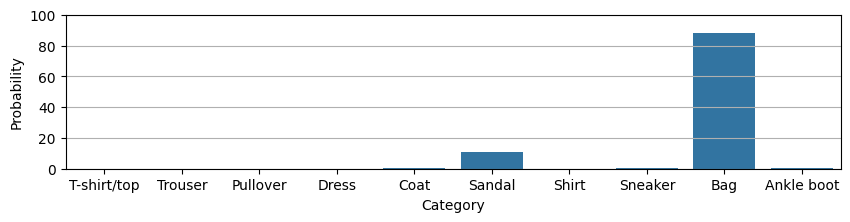

In [60]:
def _():
    plt.figure(figsize=(10, 2))
    plt.ylim(0.0, 100)
    plt.grid(True)
    sns.barplot(x="Category", y="Probability", data=df)
_()